# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


# Dataset and Creating Train/Test Split

In [2]:
from utils import get_mnist_data
train_data, test_data = get_mnist_data()

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
len(train_loader)

98

# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.05
# from model import CustomResnet
from model import ResNet18


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, criterion, scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()    # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# LR finder
Find lr using LR finder and plot it

In [8]:
!pip install torch-lr-finder
from utils import get_lr
from torch_lr_finder import LRFinder


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.43E-02


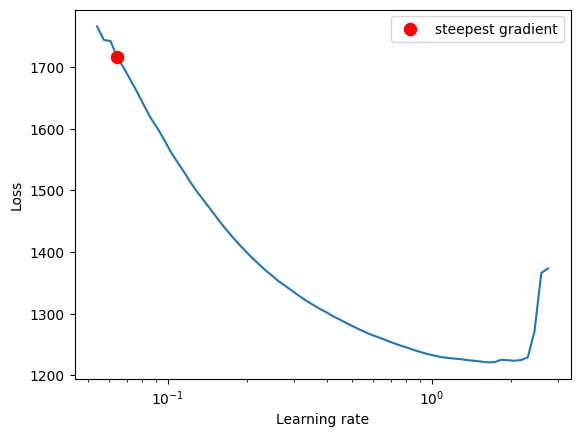

In [10]:

lr_finder = LRFinder(model, optimizer, criterion, device)
# lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader))
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()

# Training


In [11]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  ResNet18().to(device)

optimizer = optim.Adam(model.parameters(), lr=8.18E-02)

EPOCHS = 20
scheduler = OneCycleLR(
    optimizer,
    max_lr = 8.18E-02,
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100,
    three_phase = False,
    final_div_factor = 100,
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion, scheduler, epoch)
    # print("learning rate : ",get_lr(optimizer))
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=479.2016296386719 Batch_id=97 Accuracy=38.11: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 3.2155, Accuracy: 2923/10000 (29.23%)

EPOCH: 1


Loss=439.1517333984375 Batch_id=97 Accuracy=49.97: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 1.6905, Accuracy: 4804/10000 (48.04%)

EPOCH: 2


Loss=343.30450439453125 Batch_id=97 Accuracy=59.26: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 1.4644, Accuracy: 5345/10000 (53.45%)

EPOCH: 3


Loss=360.8306579589844 Batch_id=97 Accuracy=65.78: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 1.0532, Accuracy: 6504/10000 (65.04%)

EPOCH: 4


Loss=241.1177520751953 Batch_id=97 Accuracy=71.35: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.7949, Accuracy: 7380/10000 (73.80%)

EPOCH: 5


Loss=222.89059448242188 Batch_id=97 Accuracy=75.00: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 1.7084, Accuracy: 5903/10000 (59.03%)

EPOCH: 6


Loss=199.93521118164062 Batch_id=97 Accuracy=78.40: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.6902, Accuracy: 7672/10000 (76.72%)

EPOCH: 7


Loss=183.74014282226562 Batch_id=97 Accuracy=80.38: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.6018, Accuracy: 7976/10000 (79.76%)

EPOCH: 8


Loss=141.71163940429688 Batch_id=97 Accuracy=82.39: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.6148, Accuracy: 8025/10000 (80.25%)

EPOCH: 9


Loss=135.54635620117188 Batch_id=97 Accuracy=84.41: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Test set: Average loss: 0.5310, Accuracy: 8204/10000 (82.04%)

EPOCH: 10


Loss=142.7320098876953 Batch_id=97 Accuracy=86.05: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.4434, Accuracy: 8541/10000 (85.41%)

EPOCH: 11


Loss=140.52386474609375 Batch_id=97 Accuracy=87.71: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.4165, Accuracy: 8653/10000 (86.53%)

EPOCH: 12


Loss=123.05176544189453 Batch_id=97 Accuracy=88.96: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 0.4208, Accuracy: 8735/10000 (87.35%)

EPOCH: 13


Loss=83.15270233154297 Batch_id=97 Accuracy=90.52: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.3412, Accuracy: 8880/10000 (88.80%)

EPOCH: 14


Loss=86.27195739746094 Batch_id=97 Accuracy=91.98: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.3368, Accuracy: 8991/10000 (89.91%)

EPOCH: 15


Loss=57.01584243774414 Batch_id=97 Accuracy=93.42: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 0.3413, Accuracy: 9011/10000 (90.11%)

EPOCH: 16


Loss=70.1401596069336 Batch_id=97 Accuracy=94.18: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.3075, Accuracy: 9119/10000 (91.19%)

EPOCH: 17


Loss=38.989990234375 Batch_id=97 Accuracy=95.22: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.3045, Accuracy: 9156/10000 (91.56%)

EPOCH: 18


Loss=50.94062805175781 Batch_id=97 Accuracy=95.84: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 0.3048, Accuracy: 9166/10000 (91.66%)

EPOCH: 19


Loss=34.96283721923828 Batch_id=97 Accuracy=96.07: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.3047, Accuracy: 9167/10000 (91.67%)



# Train and Test loss visualisation

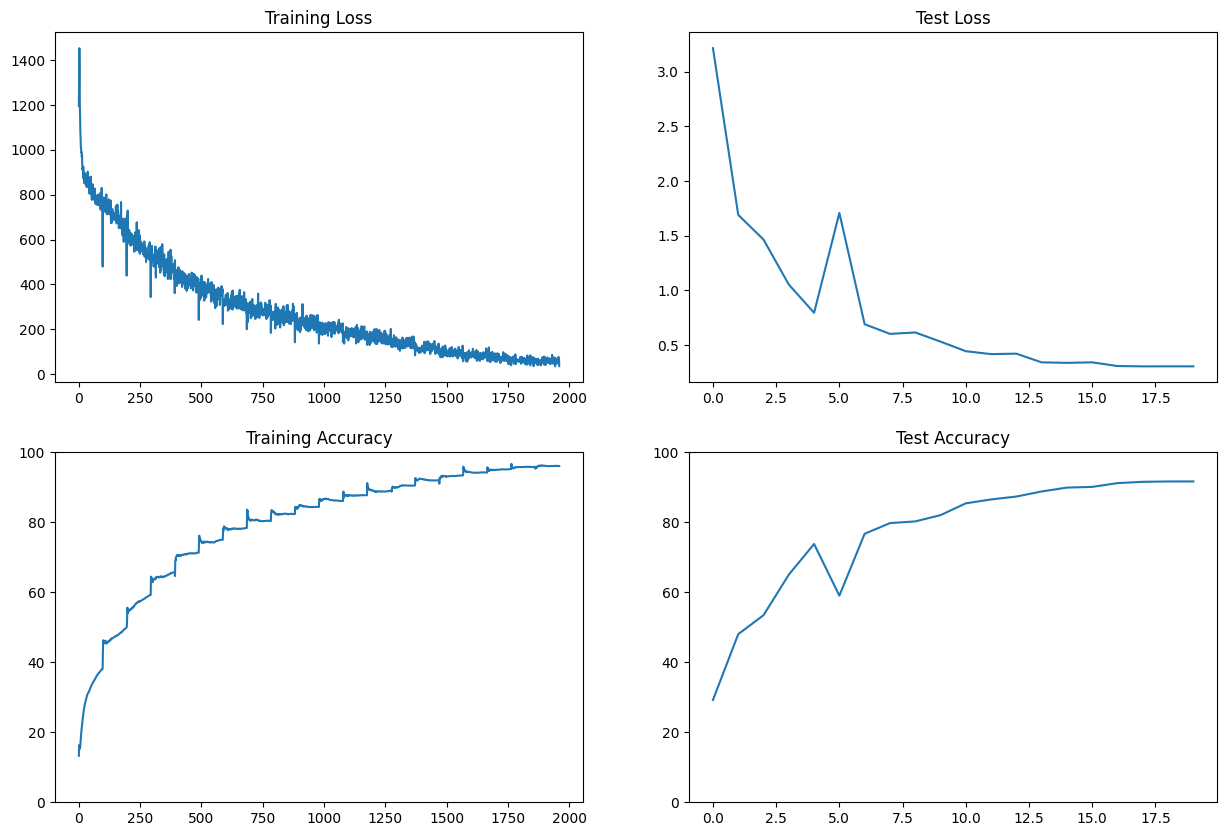

In [12]:

%matplotlib inline

from utils import plot_train_test_loss
plot_train_test_loss(train_losses, train_acc, test_losses, test_acc)

# Get misclassified images

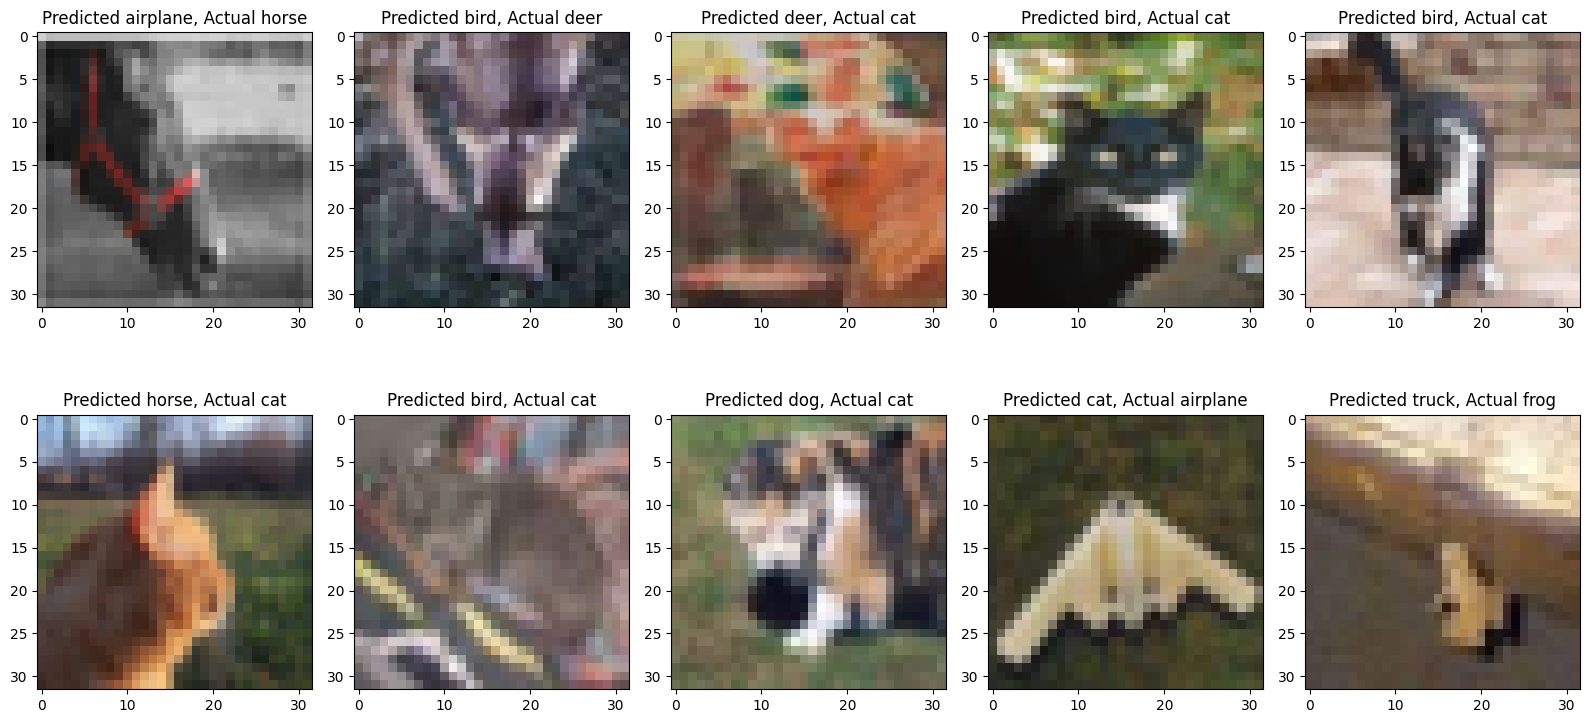

In [13]:

from utils import plot_incorrect_images

incorrect_images, predicted_labels, correct_labels = plot_incorrect_images(model,test_loader,device,n=10)


# Grad - Cam

In [14]:
!pip install grad-cam

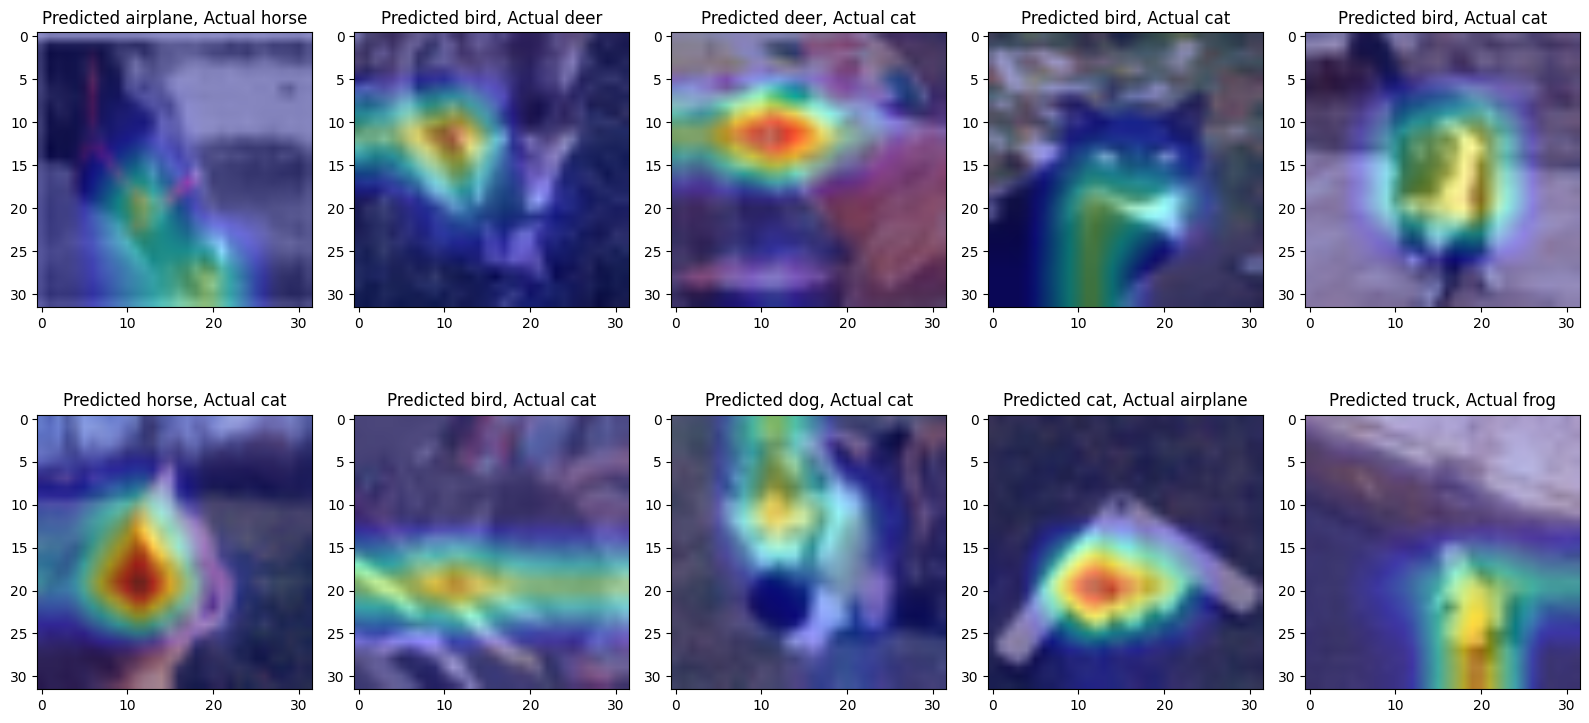

In [16]:
from utils import plot_gcam_incorrect_preds
plot_gcam_incorrect_preds(model, correct_labels, incorrect_images, predicted_labels )